In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature
using Roots


┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1664
┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1664


## Prepare data 

In [3]:
function generate_data(n, f_gp, c_gp, σ_y)
    y=[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
        push!(obs, temp + σ_y*randn())
    end
    return y , obs
end

generate_data (generic function with 1 method)

In [104]:
Random.seed!(123)
σ_y = 0.01 ## we assume low noise for now

N = 400; #data length
n = 400; #lenght of the axis of gp 
θcarrier   = 0.01
θamplitude = 0.3
mean_amplitude = (x) -> 0.0;
mean_carrier   = (x) -> 0.0;
kernel_carrier(θ)     = 0.4with_lengthscale(SqExponentialKernel(),θ)
kernel_amplitude(θ)   = with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0., 10.0
time_range = collect(range(tmin, tmax; length=n));


Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),time_range,time_range) + 1e-8*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),time_range,time_range) + 1e-8I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_test = rand(gp_amplitude)
carrier_test   = rand(gp_carrier)
#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
amplitude_train = amplitude_test[pos];
carrier_train   = carrier_test[pos]
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy = CovarianceMatrixStrategy(SoR(50))

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [105]:
#Generate data 
y_true_state,y_data = generate_data(N,amplitude_train,carrier_train,σ_y);

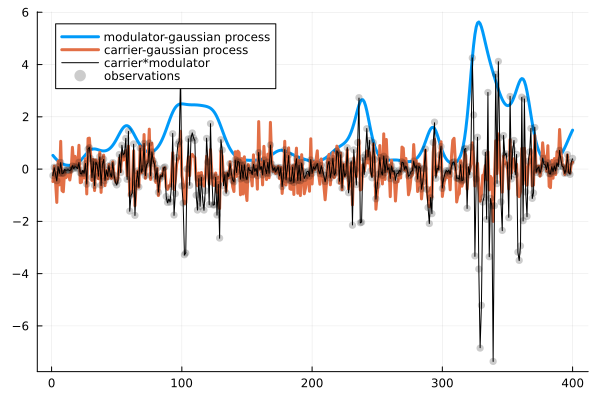

In [106]:
plot(exp.(amplitude_train), label="modulator-gaussian process",linewidth=3.0)
plot!(carrier_train,label="carrier-gaussian process",linewidth=3.0)
plot!(exp.(amplitude_train).*carrier_train,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Specify model

In [43]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [8]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1.0 : var_in = var_μ[1]

    
    return LogNormal(μ_in, var_in)
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf,m_x::GaussianDistributionsFamily, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    xsamples = rand(m_x, 1000)
    weight   = exp.(log_pdf.(xsamples)) / sum(exp.(log_pdf.(xsamples)))
    m_       = sum(weight .* xsamples)
    v_       = sum(weight .* (xsamples .- m_).^2)
    
   
#     meta = ghcubature(121)
#     m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(log_pdf(z)), mean(m_x), var(m_x))
    ksi = m_/v_ - weightedmean(m_x)
    precision = clamp(1/v_ - 1/var(m_x),0.0001,100.0)
    
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::GaussianProcess, meta::ProcessMeta) = begin 
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
    
    l_pdf = (x) -> logpdf(m_y,exp(x)) 

    meta = ghcubature(121)
    m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(l_pdf(z)), μ_in, float(var_in))
    
    
    ksi = m_/v_ - μ_in/var_in
    precision = clamp(1/v_ - 1/var_in,0.00001,100.0)
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return LogNormal(mean(m_x), var(m_x))
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [102]:
#Test with GP with fixed hyperparameters
@model function modulation(n, amplitude_kernel,amplitude_mean, carrier_kernel, carrier_mean,train,test, gpstrategy)
    amplitude   = randomprocess(test, train, gpstrategy)
    carrier     = randomprocess(test, train, gpstrategy)
    observation = datavar(Float64,n)
    g = randomvar(n)
    w = randomvar(n)

    amplitude ~ GaussianProcess(amplitude_mean, amplitude_kernel, log(θamplitude))
    carrier   ~ GaussianProcess(carrier_mean, carrier_kernel, log(θcarrier))
    for i=1:n 
        g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i)}
        w[i] ~ *(carrier, g[i]) where {meta = ProcessMeta(i)}
        observation[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
    end
end

In [10]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::Tuple, meta::TinyCorrection) = begin 
    μ_in = mean(m_in[1])
    var_in = var(m_in[1])
    
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)) - 0.5*log(2π * (var_in + var_out / x^2))  -1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)

    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    μ_in, var_in = mean_var(m_A)
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)) - 0.5*log(2π * (var_in + var_out / x^2))  - 1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)
    

    return ContinuousUnivariateLogPdf(backwardpass)
end


@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::ProcessMeta) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in,meta=TinyCorrection())
end



@rule typeof(*)(:in, Marginalisation) (m_out::NormalMeanPrecision, m_A::GaussianProcess, meta::ProcessMeta) = begin 
    
    index = meta.index
    m_gp, cov_gp = mean_cov(m_A.finitemarginal)
    kernelf = m_A.kernelfunction
    meanf   = m_A.meanfunction
    test    = m_A.testinput
    train   = m_A.traininput
    cov_strategy = m_A.covariance_strategy
    x_u = m_A.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1.0 : var_in = var_μ[1]
    d_A = NormalMeanVariance(μ_in, var_in)
    
    
    return @call_rule typeof(*)(:in, Marginalisation) (m_out=m_out,m_A=d_A,meta=TinyCorrection())
end




## Rule for multiplication node

In [11]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,1000)
    weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end




In [107]:
nits = 10

iresult = inference(
    model = modulation(length(y_data), kernel_amplitude,mean_amplitude, kernel_carrier,mean_carrier, time_train,time_range, cov_strategy),
    initmessages = (carrier   = GaussianProcess(mean_carrier,kernel_carrier(θcarrier),MvNormalMeanCovariance(ones(n),Cov_carrier),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
#                     amplitude = GaussianProcess(mean_amplitude,kernel_amplitude(θamplitude),MvNormalMeanCovariance(ones(n),Cov_amplitude),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits, 
    returnvars = (amplitude=KeepEach(),carrier=KeepEach()),
    data  = (observation = y_data,),
    showprogress = true,
    free_energy = false,
)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


Inference results:
  Posteriors       | available for (amplitude, carrier)


In [108]:
mamplitude = mean(iresult.posteriors[:amplitude][end].data.finitemarginal)
vamplitude = var(iresult.posteriors[:amplitude][end].data.finitemarginal)
expvgp = exp.( mamplitude .+ vamplitude)
expmgp = exp.(mamplitude);

mcarriers = mean(iresult.posteriors[:carrier][end].data.finitemarginal)
vcarriers = var(iresult.posteriors[:carrier][end].data.finitemarginal);

In [112]:
# plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# # plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,exp.(amplitude_test), label="modulator GP-true",linewidth=3.0,color=:blue)
# # plot!(time_train,y_true_state, label="modulated signal",color=:black)
# plot!(time_range,mcarriers,ribbon=sqrt.(vcarriers),linewidth=3.0,label="carrier GP-estimated",fillalpha=0.2,color=:red)
# # scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)
# plot!(time_range,carrier_test,linewidth=3.0, color="yellow", label="GP carrier true")

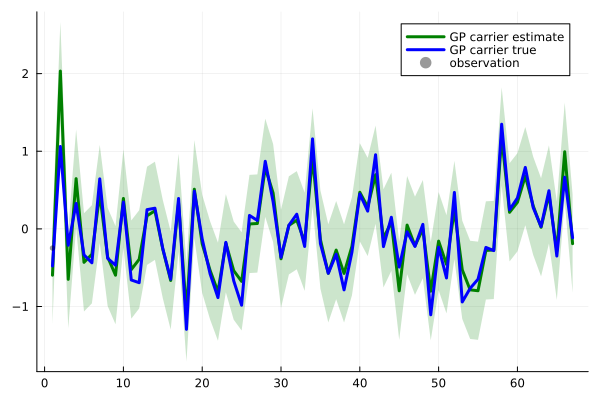

In [116]:
from = 1
to   = N
skip = 6

plot(mcarriers[from:skip:to],ribbon=sqrt.(vcarriers[from:skip:to]),label="GP carrier estimate",linewidth=3.0, fillalpha=0.2, color="green")
plot!(carrier_test[from:skip:to],linewidth=3.0, color="blue", label="GP carrier true")
# scatter!(y_data[from:to:skip], label="observation",color=:black,alpha=0.4,ms=3)

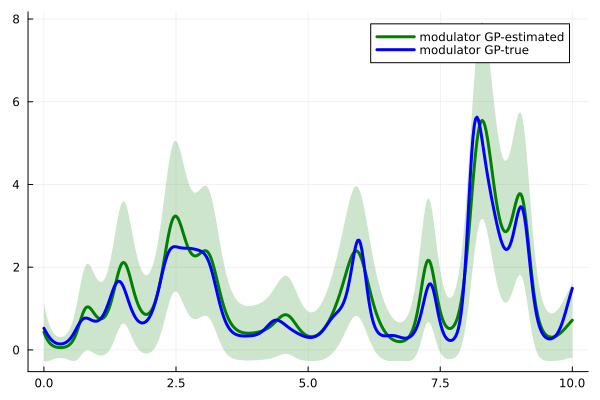

In [114]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(amplitude_test), label="modulator GP-true",linewidth=3.0,color=:blue)
